In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [8]:
# 데이터셋 로드 및 전처리
transform = transforms.Compose([
    transforms.ToTensor(),   # 이미지를 텐서로 변환
    transforms.Normalize((0.5,), (0.5,))  # 텐서 값 정규화
])

# 데이터셋을 불러올 때, transform 인자를 통해 정의된 변환 작업이 각 이미지에 적용
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # 인코더 정의
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )
        # 디코더 정의
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Tanh()
        )
        
    def forward(self, x):
        x = self.encoder(noise(x))
        x = self.decoder(x)
        return x
    
def noise(x, noise_factor=0.5):
    noise = torch.randn_like(x) * noise_factor
    return x + noise

model = Autoencoder().to(device)

# 모델의 학습을 위한 손실함수와 최적화 알고리즘 설정
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [11]:
print(model)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=784, bias=True)
    (5): Tanh()
  )
)


In [12]:
num_epochs = 10

for epoch in range(num_epochs):
    for data, _ in train_loader:
        data = data.view(-1, 28 * 28).to(device)
        
        # 순전파
        output = model(data)
        loss = criterion(output, data)
        
        # 역전파
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/10], Loss: 0.1148
Epoch [2/10], Loss: 0.0764
Epoch [3/10], Loss: 0.0637
Epoch [4/10], Loss: 0.0596
Epoch [5/10], Loss: 0.0598
Epoch [6/10], Loss: 0.0589
Epoch [7/10], Loss: 0.0643
Epoch [8/10], Loss: 0.0533
Epoch [9/10], Loss: 0.0526
Epoch [10/10], Loss: 0.0464


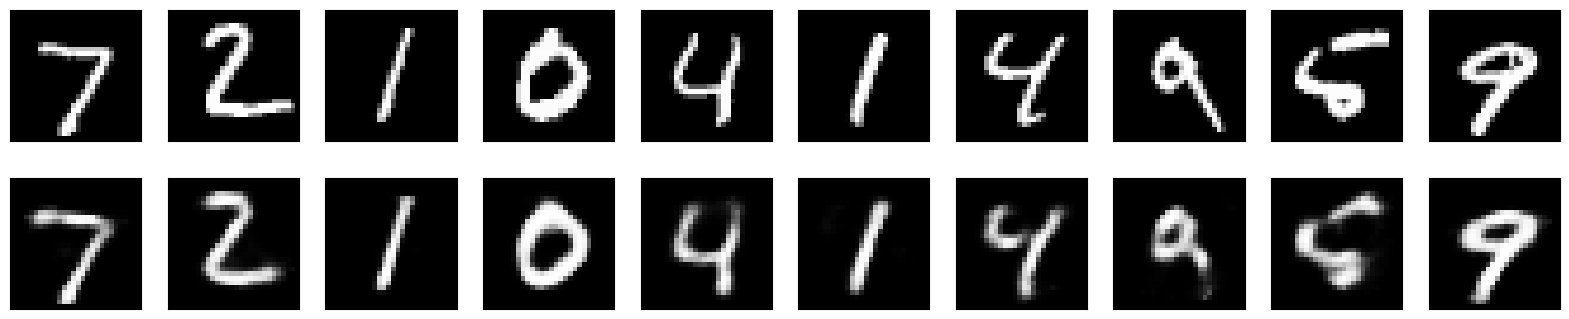

In [13]:
# 테스트 데이터로 복원 이미지 생성 및 시각화
model.eval()
with torch.no_grad():
    for data, _ in test_loader:
        data = data.view(-1, 28 * 28).to(device)
        output = model(data)
        output = output.view(-1, 1, 28, 28).cpu()
        break
        
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))

for images, row in zip([data.view(-1, 1, 28, 28).cpu(), output], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.numpy().squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
plt.show()